In [1]:
ls

ATML-PA-2/


In [2]:
cd ATML-PA-2/Baseline

/kaggle/working/ATML-PA-2/Baseline


In [29]:
%load_ext autoreload
%autoreload 2

In [46]:
import importlib
import utils
import architecture
import train
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [31]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

classes = os.listdir(f"{root_dir}/Art")


In [ ]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):

    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x

    import types
    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    train_workflow(truncated_model, cache_source, cache_target, config, device=device)
    evaluate_ds(cache_target, truncated_model, device, target[0], None)

    latents_s, labels_s = get_features(truncated_model[:-1], cache_source, batchsize=32, device=device)
    latents_t, labels_t = get_features(truncated_model[:-1], cache_target, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [34]:
model = resnet_classifier(num_classes=len(classes))

In [35]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [37]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.25196 |  Train acc: 69.39 %

Test loss: 2.22254 | Test acc: 45.68 %



Training:  10%|█         | 1/10 [00:17<02:33, 17.03s/it]


Epoch 2/10

Train loss: 0.39333 |  Train acc: 89.49 %

Test loss: 2.33447 | Test acc: 45.86 %



Training:  20%|██        | 2/10 [00:33<02:13, 16.64s/it]


Epoch 3/10

Train loss: 0.16557 |  Train acc: 96.00 %

Test loss: 2.34414 | Test acc: 46.76 %



Training:  30%|███       | 3/10 [00:49<01:55, 16.45s/it]


Epoch 4/10

Train loss: 0.07441 |  Train acc: 98.58 %

Test loss: 2.42757 | Test acc: 46.55 %



Training:  40%|████      | 4/10 [01:05<01:37, 16.31s/it]


Epoch 5/10

Train loss: 0.04301 |  Train acc: 99.24 %

Test loss: 2.45924 | Test acc: 46.71 %



Training:  50%|█████     | 5/10 [01:22<01:22, 16.53s/it]


Epoch 6/10

Train loss: 0.03203 |  Train acc: 99.40 %

Test loss: 2.50014 | Test acc: 47.49 %



Training:  60%|██████    | 6/10 [01:39<01:06, 16.53s/it]


Epoch 7/10

Train loss: 0.02418 |  Train acc: 99.48 %

Test loss: 2.59990 | Test acc: 46.44 %



Training:  70%|███████   | 7/10 [01:55<00:49, 16.54s/it]


Epoch 8/10

Train loss: 0.02020 |  Train acc: 99.48 %

Test loss: 2.52785 | Test acc: 47.54 %



Training:  80%|████████  | 8/10 [02:12<00:32, 16.47s/it]


Epoch 9/10

Train loss: 0.01800 |  Train acc: 99.55 %

Test loss: 2.70244 | Test acc: 46.64 %



Training:  90%|█████████ | 9/10 [02:28<00:16, 16.36s/it]


Epoch 10/10

Train loss: 0.01559 |  Train acc: 99.54 %

Test loss: 2.54929 | Test acc: 47.29 %



Training: 100%|██████████| 10/10 [02:45<00:00, 16.53s/it]



=== Evaluation for Clipart Domain ===
Accuracy: 47.29%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.6429    0.7500    0.6923        60
           1     0.7647    0.2321    0.3562        56
           2     0.4510    0.3594    0.4000        64
           3     0.8333    0.1531    0.2586        98
           4     0.9268    0.7677    0.8398        99
           5     0.6429    0.2727    0.3830        99
           6     0.4844    0.4247    0.4526        73
           7     0.6269    0.9130    0.7434        46
           8     0.4615    0.6154    0.5275        78
           9     0.6078    0.3131    0.4133        99
          10     0.7313    0.4949    0.5904        99
          11     0.1429    0.1000    0.1176        40
          12     0.3596    0.4141    0.3850        99
          13     0.7000    0.3281    0.4468        64
          14     0.7105    0.6429    0.6750        42
          15     0.1447    0.2683   

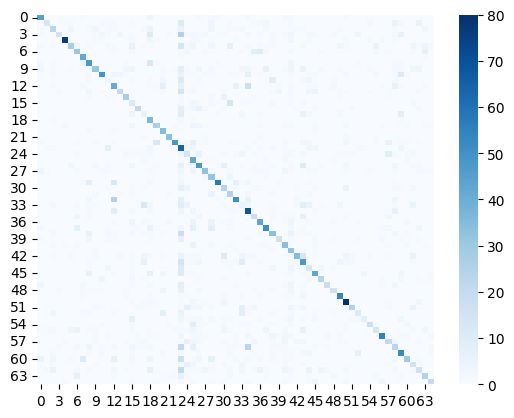

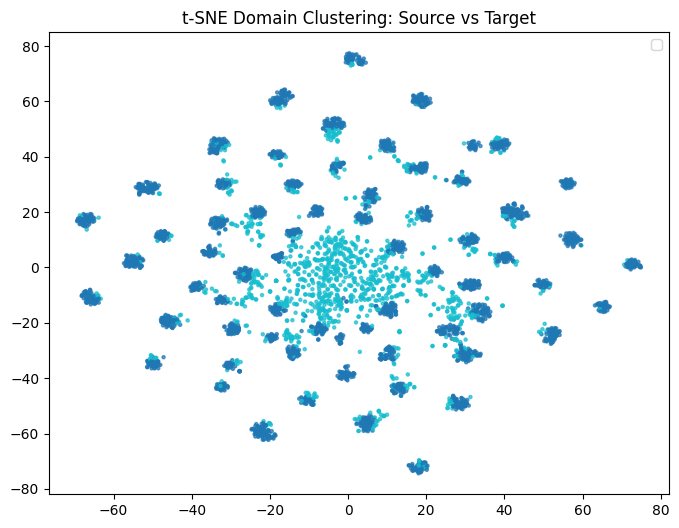

In [48]:
config = {'epochs':10, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target, )

In [50]:
#benchmark for domain adaptation
torch.manual_seed(100)
_, da_benchmark = torch.utils.data.random_split(cache_target, [0.8, 0.2])

Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.24272 |  Train acc: 69.83 %

Test loss: 2.29180 | Test acc: 44.67 %



Training:  10%|█         | 1/10 [00:14<02:12, 14.76s/it]


Epoch 2/10

Train loss: 0.40496 |  Train acc: 88.73 %

Test loss: 2.49490 | Test acc: 43.30 %



Training:  20%|██        | 2/10 [00:29<01:57, 14.74s/it]


Epoch 3/10

Train loss: 0.17066 |  Train acc: 96.04 %

Test loss: 2.40603 | Test acc: 45.48 %



Training:  30%|███       | 3/10 [00:44<01:44, 14.90s/it]


Epoch 4/10

Train loss: 0.07836 |  Train acc: 98.46 %

Test loss: 2.53381 | Test acc: 47.42 %



Training:  40%|████      | 4/10 [00:59<01:28, 14.83s/it]


Epoch 5/10

Train loss: 0.04589 |  Train acc: 99.16 %

Test loss: 2.48163 | Test acc: 47.42 %



Training:  50%|█████     | 5/10 [01:14<01:14, 14.97s/it]


Epoch 6/10

Train loss: 0.03294 |  Train acc: 99.39 %

Test loss: 2.54446 | Test acc: 47.54 %



Training:  60%|██████    | 6/10 [01:29<00:59, 14.99s/it]


Epoch 7/10

Train loss: 0.02401 |  Train acc: 99.51 %

Test loss: 2.56714 | Test acc: 47.65 %



Training:  70%|███████   | 7/10 [01:44<00:44, 14.91s/it]


Epoch 8/10

Train loss: 0.02046 |  Train acc: 99.53 %

Test loss: 2.59180 | Test acc: 46.05 %



Training:  80%|████████  | 8/10 [01:58<00:29, 14.64s/it]


Epoch 9/10

Train loss: 0.01696 |  Train acc: 99.57 %

Test loss: 2.73054 | Test acc: 46.16 %



Training:  90%|█████████ | 9/10 [02:13<00:14, 14.70s/it]


Epoch 10/10

Train loss: 0.01486 |  Train acc: 99.57 %

Test loss: 2.68975 | Test acc: 46.51 %



Training: 100%|██████████| 10/10 [02:27<00:00, 14.79s/it]



=== Evaluation for Clipart Domain ===
Accuracy: 46.51%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.5556    0.5263         9
           1     0.8000    0.4000    0.5333        10
           2     0.5000    0.2000    0.2857        10
           3     0.5000    0.0455    0.0833        22
           4     1.0000    0.8400    0.9130        25
           5     0.8571    0.3529    0.5000        17
           6     0.7000    0.4667    0.5600        15
           7     0.4737    0.9000    0.6207        10
           8     0.3000    0.4615    0.3636        13
           9     0.4667    0.3182    0.3784        22
          10     0.7333    0.5500    0.6286        20
          11     0.4167    0.5000    0.4545        10
          12     0.3333    0.3077    0.3200        26
          13     1.0000    0.2222    0.3636         9
          14     0.6667    0.3333    0.4444         6
          15     0.1818    0.1818   

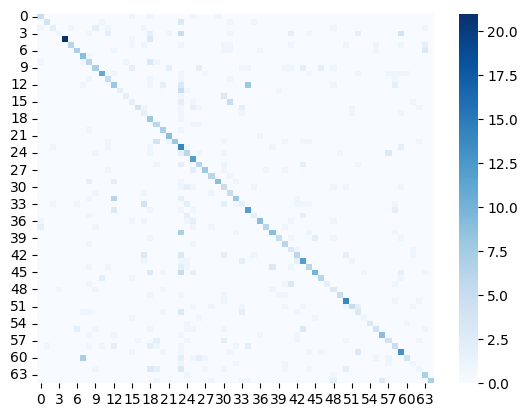

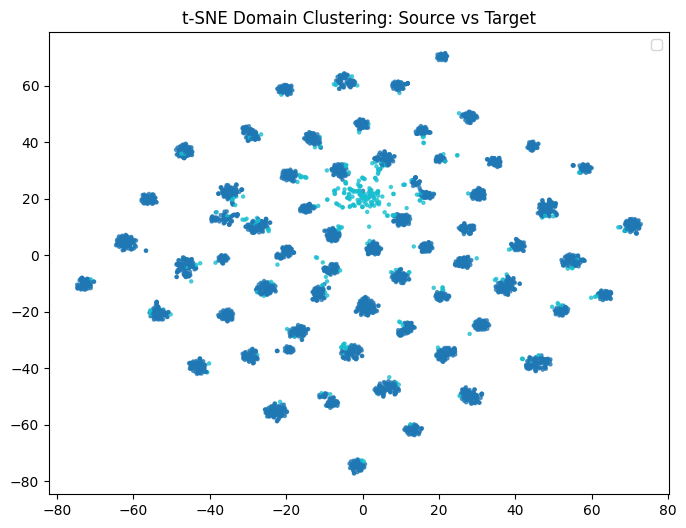

: 

In [ ]:
config = {'epochs':10, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=da_benchmark,)